# CarMax Analytics Showcase: Winter 2023
## Rory Stevens
Desc

In [53]:
# Imports
import re
import time
import math
import pandas as pd
import missingno as msno
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR, SVC
from sklearn.decomposition import PCA


### Data Loading and Preliminary Processing

In [2]:
raw_df = pd.read_csv("./Data/ShowcaseDataWinter2023.csv")
raw_memory = raw_df.memory_usage(deep=True).sum()
# To conserve energy, compute time --> limit_size = a number

print(f'Shape: {raw_df.shape}\nMemory Usage: {raw_memory} bytes ... {raw_memory/1000000:.2f} Mb')
raw_df.head()

Shape: (200000, 30)
Memory Usage: 224052594 bytes ... 224.05 Mb


,price,appraisal_offer,online_appraisal_flag,model_year,mileage,make,model,trim_descrip,body,color,...,trim_descrip_appraisal,body_appraisal,color_appraisal,engine_appraisal,cylinders_appraisal,mpg_city_appraisal,mpg_highway_appraisal,horsepower_appraisal,fuel_capacity_appraisal,market
0,$20k to $25k,$0k to $5k,1.0,2014.0,15k to 20k miles,HDT,HDT_12,Premium,E,Red,...,NaN,D,Silver,4.0L,6,17.0,21,236,21.0,13
1,$15k to $20k,$0k to $5k,0.0,2006.0,100k+ miles,KQZ,KQZ_23,Premium,E,Silver,...,Not Premium,D,Gold,4.2L,6,16.0,21,205,25.0,11
2,$30k to $35k,$35k to $40k,1.0,2014.0,5k to 10k miles,CZV,CZV_10,Premium,E,Black,...,NaN,E,Red,2.0L,4,41.0,38,181,10.0,13
3,$35k to $40k,$5k to $10k,1.0,2014.0,15k to 20k miles,IZA,IZA_19,Premium,F,Silver,...,Premium,F,Blue,3.0L,6,17.0,25,230,16.0,13
4,$30k to $35k,$15k to $20k,1.0,2011.0,35k to 40k miles,HDT,HDT_8,Premium,F,Blue,...,Not Premium,E,Black,2.4L,4,20.0,29,182,18.0,16


Taking a look at the 30 features, it is apparent that there are some features that need conversion to numeric values, namely the features denoted with ranges (ex. "20k to 25k miles").

In [3]:
# Can use a smaller portion of dataset for working on underpowered machines (or machines with small amount of available memory)
use_limited = False

if use_limited:
    raw_df = raw_df.iloc[:300,:]
    print(raw_df.shape)
    raw_df.head()

#### Take a look at dataset info with df.info()

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   price                    200000 non-null  object 
 1   appraisal_offer          200000 non-null  object 
 2   online_appraisal_flag    196166 non-null  float64
 3   model_year               200000 non-null  float64
 4   mileage                  200000 non-null  object 
 5   make                     200000 non-null  object 
 6   model                    200000 non-null  object 
 7   trim_descrip             176159 non-null  object 
 8   body                     189741 non-null  object 
 9   color                    199967 non-null  object 
 10  engine                   200000 non-null  object 
 11  cylinders                200000 non-null  int64  
 12  mpg_city                 199410 non-null  float64
 13  mpg_highway              199410 non-null  float64
 14  hors

We can see that the majority of features are entirely non-null, and there are a majority of features are objects.

#### Converting range features

The range representation of `price`, `appraisal_offer`, `mileage`, and `mileage_appraisal` is good for human readability, but for analyzing the data, it would be best to represent them as numerical values. So, if we take the midpoint of these ranges, we can preserve the relationship while changing the features to numeric values.

We don't know where the actual dollar amount or mileage number lies in these ranges, so no data is lost in this process.

In [5]:
def convert_range(range_ : str) -> np.float64:
    '''
    Converts rages (ex. price and mileage) to their midpoint as a float
    :param range_:
    :return:
    '''
    return np.average(list(map(int, re.findall(r'\d+', range_))))

In [6]:
print(raw_df.price.unique())
print('\n', raw_df.appraisal_offer.unique())
print('\n', raw_df.mileage.unique())
print('\n', raw_df.mileage_appraisal.unique())

['$20k to $25k' '$15k to $20k' '$30k to $35k' '$35k to $40k'
 '$45k to $50k' '$25k to $30k' '$40k to $45k' '$0 to $15k' '$55k to $60k'
 '$60k to $65k' '$65k to $70k' '$70k+' '$50k to $55k']

 ['$0k to $5k' '$35k to $40k' '$5k to $10k' '$15k to $20k' '$40k+'
 '$20k to $25k' '$10k to $15k' '$25k to $30k' '$30k to $35k']

 ['15k to 20k miles' '100k+ miles' '5k to 10k miles' '35k to 40k miles'
 '20k to 25k miles' '30k to 35k miles' '45k to 50k miles'
 '70k to 75k miles' '25k to 30k miles' '0 to 5k miles' '10k to 15k miles'
 '80k to 85k miles' '65k to 70k miles' '75k to 80k miles'
 '55k to 60k miles' '50k to 55k miles' '85k to 90k miles'
 '40k to 45k miles' '90k to 95k miles' '95k to 100k miles'
 '60k to 65k miles']

 ['200k+ miles' '0 to 10k miles' '10k to 20k miles' '100k to 110k miles'
 '20k to 30k miles' '160k to 170k miles' '30k to 40k miles'
 '80k to 90k miles' '60k to 70k miles' '110k to 120k miles'
 '70k to 80k miles' '90k to 100k miles' '190k to 200k miles'
 '150k to 160k miles' '1

Using `df.unique()`, we see that the maximum values for `price`, `appraisal_offer`, `mileage`, and `mileage_appraisal` are &#36;70k+, &#36;40k+, 100k+ miles, and 200k+ miles, respectively.

This means that the values have hard-capped ranges, which will be useful later in Memory Optimization.

In [7]:
# String features that represent numerical ranges
range_feats = ['price', 'appraisal_offer', 'mileage', 'mileage_appraisal']

# Convert each range-based feature value to the midpoint of the range. These are then kept as float as there exists an ordinal relationship.
for feature in range_feats:
    raw_df[feature] = raw_df[feature].apply(convert_range)
# Confirm changes with .dtypes and .head()

In [8]:
# Check conversion with df.head()
raw_df.head()

,price,appraisal_offer,online_appraisal_flag,model_year,mileage,make,model,trim_descrip,body,color,...,trim_descrip_appraisal,body_appraisal,color_appraisal,engine_appraisal,cylinders_appraisal,mpg_city_appraisal,mpg_highway_appraisal,horsepower_appraisal,fuel_capacity_appraisal,market
0,22.5,2.5,1.0,2014.0,17.5,HDT,HDT_12,Premium,E,Red,...,NaN,D,Silver,4.0L,6,17.0,21,236,21.0,13
1,17.5,2.5,0.0,2006.0,100.0,KQZ,KQZ_23,Premium,E,Silver,...,Not Premium,D,Gold,4.2L,6,16.0,21,205,25.0,11
2,32.5,37.5,1.0,2014.0,7.5,CZV,CZV_10,Premium,E,Black,...,NaN,E,Red,2.0L,4,41.0,38,181,10.0,13
3,37.5,7.5,1.0,2014.0,17.5,IZA,IZA_19,Premium,F,Silver,...,Premium,F,Blue,3.0L,6,17.0,25,230,16.0,13
4,32.5,17.5,1.0,2011.0,37.5,HDT,HDT_8,Premium,F,Blue,...,Not Premium,E,Black,2.4L,4,20.0,29,182,18.0,16


#### Changing engine sizes (contains 'L') to numerical values

We can safely remove the 'L' at the end of the values in the two engine features, because we know that all values in this column share the same unit, liters.

Important Note:
The units of engine size are almost always expressed as liters, but it is important to remember, as a general case, that it cannot always be assumed that units are consistent. You could lose information by removing unit designation.

In [9]:
slice_feats = ['engine', 'engine_appraisal']

for feature in slice_feats:
    # Get rid of last character
    raw_df[feature] = raw_df[feature].str.slice(start = 0, stop = -1)
    # Convert column to numeric and downcast
    raw_df[feature] = pd.to_numeric(raw_df[feature], downcast = "float")
print(f'New dtype for engine and engine_appraisal: {raw_df.engine.dtype}')

New dtype for engine and engine_appraisal: float32


## Memory Optimization

Memory optimization in a Jupyter notebook such as this would only be for the purposes of preventing memory errors and slow performance on constrained hardware. However, it is worth noting the data types and ways to optimize memory usage to get a better understanding of the data, their possible values, and optimal ways to store such data.

For nullable integers, we can use the nullable-integer extension dtypes in pandas
- Int8
- Int16
- Int32
- Int64


In [10]:
# Begin building the schema
# We already know the range features we converted are np.float64 given that we used np.average
# They also have hard limits, so we can safely use a smaller float dtype
schema={
    'price' : 'float16',
    'appraisal_offer': 'float16',
    'mileage' : 'float16',
    'mileage_appraisal' : 'float16'
}

#### Fuel Capacity

In [11]:
# Looking at fuel_capacity and fuel_capacity_appraisal..
print(raw_df['fuel_capacity'].unique())
print(raw_df['fuel_capacity_appraisal'].unique())
# All unique values can be represented by a nullable Int16 without losing data
schema['fuel_capacity'] = 'Int16'

[16. 18. 15. 19. 14. 31. 12. 13. 17. 24. 22. 38. 26. 28.  7. 21. 11. 23.
 20. 36.  8. 10. 35.  9. 27. 32. 48. 34. 25.  2. 29. nan 33.  1. 41. 30.
 37.]
[21. 25. 10. 16. 18. 19. 13. 22. 20. 14. 17. 26. 15. 23. 11. 12. 28. 24.
 31. nan 36.  9. 34. 35. 30.  8. 38. 27. 32. 33.  7. 42. 29. 48. 37. 39.]


It appears that fuel capacity values can be stored as a nullable Int16

#### Model Year
model_year and model_year_appraisal, with type float64, can be better stored as int32 since years are inherently unsigned 'small' integers (we will keep it as signed in case some special encoding is needed later). There are also no NaN's present, so a nullable type is not needed


In [12]:
schema['model_year'] = 'int32'
schema['model_year_appraisal'] = 'int32'

#### Online Appraisal Flag

In [13]:
# Looking at the online appraisal feature, it appears that it is a binary feature with missing values.
print(raw_df.online_appraisal_flag.unique())
schema['online_appraisal_flag'] = 'category'
# Although this is converting the dtype to Int8, this feature will be re-encoded as a categorical feature later

[ 1.  0. nan]


#### Make
There is a set of distinct makes, so we can make this a categorical variable

In [14]:
print(raw_df.make.unique())
schema['make'] = 'category'

['HDT' 'KQZ' 'CZV' 'IZA' 'OFW' 'LTX' 'FVQ' 'ARU' 'HXQ' 'BDP' 'CFK' 'CIP'
 'AIH' 'JHO' 'BGZ' 'FJE' 'MBN' 'JJQ' 'NHY' 'NKR' 'GUK' 'LYP' 'JDZ' 'BZQ'
 'HAE' 'BXO' 'FPH' 'HYS' 'JGV' 'HAN' 'NAJ' 'NYP' 'IZN' 'DVE' 'KDM' 'FJR'
 'BIS']


#### Model
The model distinction is far more specific than make (intuitively), so it makes more sense to keep this as an object. Additionally, if we extracted the model number from this feature and simply made that a column of itself for better readability/differentiation, it would misrepresent the data because a model 10 on one make is not the same as a model 10 on another.

In [15]:
print(f'Number of models : {len(raw_df.model.unique())}')

Number of models : 575


#### Trim Description, Body, Color
These features appear to be categorical in nature with some NaN values, so the best dtype would be category.

In [16]:
print(f'trim_descrip: {raw_df.trim_descrip.unique()}')
print(f'\nbody: {raw_df.body.unique()}')
print(f'\ncolor: {raw_df.color.unique()}')
schema['trim_descrip'] = 'category'
schema['trim_descrip_appraisal'] = 'category'
schema['body'] = 'category'
schema['body_appraisal'] = 'category'
schema['color'] = 'category'
schema['color_appraisal'] = 'category'

trim_descrip: ['Premium' 'Not Premium' nan]

body: ['E' 'F' 'B' nan 'D' 'G' 'A']

color: ['Red' 'Silver' 'Black' 'Blue' 'White' 'Gray' 'Burgundy' 'Gold' 'Brown'
 'Green' 'Pearl' 'Purple' 'Tan' 'Orange' nan 'Yellow' 'Unknown']


#### Engine
We already found that the two engine features were best changed to floats because the unit designation of 'L' was constant and they are continuous (somewhat) values.

Additionally, since engine sizes cannot be extremely large values, we already downcast the output from our conversion to numeric.

In [17]:
print(f'Data type of engine and engine_appraisal after conversion: {raw_df.engine.dtype}')

Data type of engine and engine_appraisal after conversion: float32


#### Cylinders
The cylinders feature has an ordinal relationship and a typically defined range, so we can change this to int16 since it also has no null values.

In [18]:
print(f'Unique cylinder values: {raw_df.cylinders.unique()}')
print(f'Unique appraised cylinder values: {raw_df.cylinders_appraisal.unique()}')
schema['cylinders'] = 'int16'
schema['cylinders_appraisal'] = 'int16'

Unique cylinder values: [ 4  6  8  3  0  5  2 10 12 16]
Unique appraised cylinder values: [ 6  4  8  5  3 10]


#### MPG, Fuel Capacity, and  Horsepower
mpg_city, mpg_highway, fuel_capacity, and horsepower for the purchased and appraised vehicle have dtypes of float64, float64, float64, and int64. Because mpg_city, mpg_highway have null values, we can keep these as float64 (a nullable type). For horsepower, an integer column which has no null values, we can save memory and downcast this column.

In [19]:
print(f'Horsepower max: {raw_df.horsepower.max()}\nHorsepower Min: {raw_df.horsepower.min()}')
schema['horsepower'] = 'int32'
schema['horsepower_appraisal'] = 'int32'

Horsepower max: 760
Horsepower Min: 11


#### Market
Market is listed as a string value representing the market in which the transaction occurred. This means that this number has no ordinal relationship, so it should be made a categorical column.

In [20]:
print(f'Market Max: {raw_df.market.max()}\nMarket Min: {raw_df.market.min()}')
print(sorted(raw_df.market.unique()))
schema['market'] = 'category'

Market Max: 16
Market Min: 1
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


#### Data type inspection and Memory Optimization: Conclusions

Using the schema created during our inspection of the feature's data types, we can get a ~75% reduction in memory usage! Again, this is not a requirement for performing data science tasks, but it is certainly a good exercise on learning where performance can be gained when working with large amounts of data. In a data storage layer, this data is certainly optimized to be as small as possible to save on costs; however, its

In [21]:
# Astype conversion
trimmed_raw_df = raw_df.astype(schema)
trimmed_raw_memory = trimmed_raw_df.memory_usage(deep=True).sum()

print(f'Raw Dataframe Memory Usage: {raw_memory} bytes ... {raw_memory/1000000:.2f} Mb')
print(f'Optimized Dataframe Memory Usage: {trimmed_raw_memory} bytes ... {trimmed_raw_memory/1000000:.2f} Mb')
print(f'% Memory Reduction from raw dataframe to optimized dataframe {((raw_memory - trimmed_raw_memory) / raw_memory * 100) : .2f} %\n')
trimmed_raw_df.info()

Raw Dataframe Memory Usage: 224052594 bytes ... 224.05 Mb
Optimized Dataframe Memory Usage: 53965739 bytes ... 53.97 Mb
% Memory Reduction from raw dataframe to optimized dataframe  75.91 %

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   price                    200000 non-null  float16 
 1   appraisal_offer          200000 non-null  float16 
 2   online_appraisal_flag    196166 non-null  category
 3   model_year               200000 non-null  int32   
 4   mileage                  200000 non-null  float16 
 5   make                     200000 non-null  category
 6   model                    200000 non-null  object  
 7   trim_descrip             176159 non-null  category
 8   body                     189741 non-null  category
 9   color                    199967 non-null  category
 10  engine               

### Analyzing Nulls

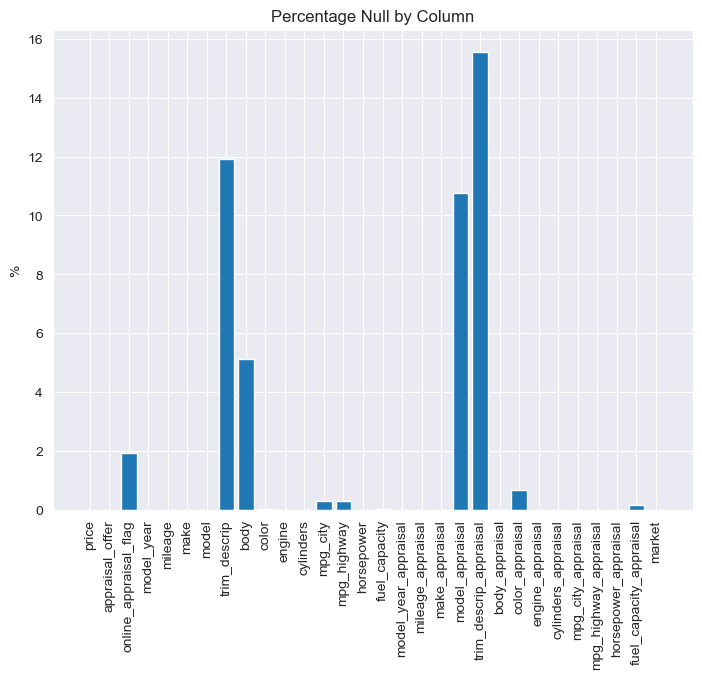

In [22]:
# Make a list of the percentage of null values for each column
null_portions = [(trimmed_raw_df[column].isnull().sum()/trimmed_raw_df.shape[0]*100) for column in trimmed_raw_df.columns ]
null_dict = dict(zip(list(trimmed_raw_df.columns), null_portions))

# Plot the null percentage for each column
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(trimmed_raw_df.columns), null_portions)
plt.xticks(rotation = 90)
plt.title("Percentage Null by Column")
plt.ylabel("%")
plt.show()

Looking at the % of null values in each column, it appears that `online_appraisal_flag`, `trim_descrip`, `body`, `model_appraisal`, and `trim_descrip_appraisal` have significant portions of nulls, with `mpg_city`, `mpg_highway`, `color_appraisal`, and `fuel_capacity_appraisal` having a small number of nulls as well.

The next question we can formulate from this information is, "How concentrated are these null values?".

To check this, we can look at the portion of rows that have at least one null.


In [23]:
print(f'Rows that have at least one null:\nCount - {trimmed_raw_df.isna().any(axis=1).sum()}\nPercentage - {trimmed_raw_df.isna().any(axis=1).sum()/trimmed_raw_df.shape[0]*100:.2f}%')

Rows that have at least one null:
Count - 71317
Percentage - 35.66%


If we look at the percentage of rows that have null values, we can see that it represents over a third of our dataset!
This means that our null values are not entirely concentrated (ex. rows with multiple nulls).
If rows with null values made up only as much as our most null column, we could potentially justify dropping them entirely.

Now we need to analyze our null rows against non-null, to check if there are any striking differences in distribution.

In [49]:
numerical_columns = trimmed_raw_df.select_dtypes(include = 'number').columns
categorical_columns = trimmed_raw_df.select_dtypes(exclude = 'number').columns

In [25]:
def compare_hists(df : pd.DataFrame, features, rows : int , cols : int):
    # Null and partial null subset creation
    nn_df = df.dropna(axis = 0, how ="any")
    n_df = df[df.isna().any(axis=1)]

    # Plot creation for each feature
    fig = plt.figure(figsize=(25,100),)
    for i, feat in enumerate(features):
        ax = fig.add_subplot(rows,cols,i+1)
        nn_df[feat].hist(bins=75,ax=ax, alpha=0.5, color = 'green', label = 'Non-null', density = True)
        n_df[feat].hist(bins = 75,ax = ax, alpha = 0.5, color = 'red', label ='Null', density = True)
        plt.legend(loc='upper right')
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)
        ax.set_title(f"Null vs Non-null: {feat}", fontdict={'fontsize': 18})


    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.2,
                        hspace=0.5)  # Improves appearance a bit.
    plt.show()

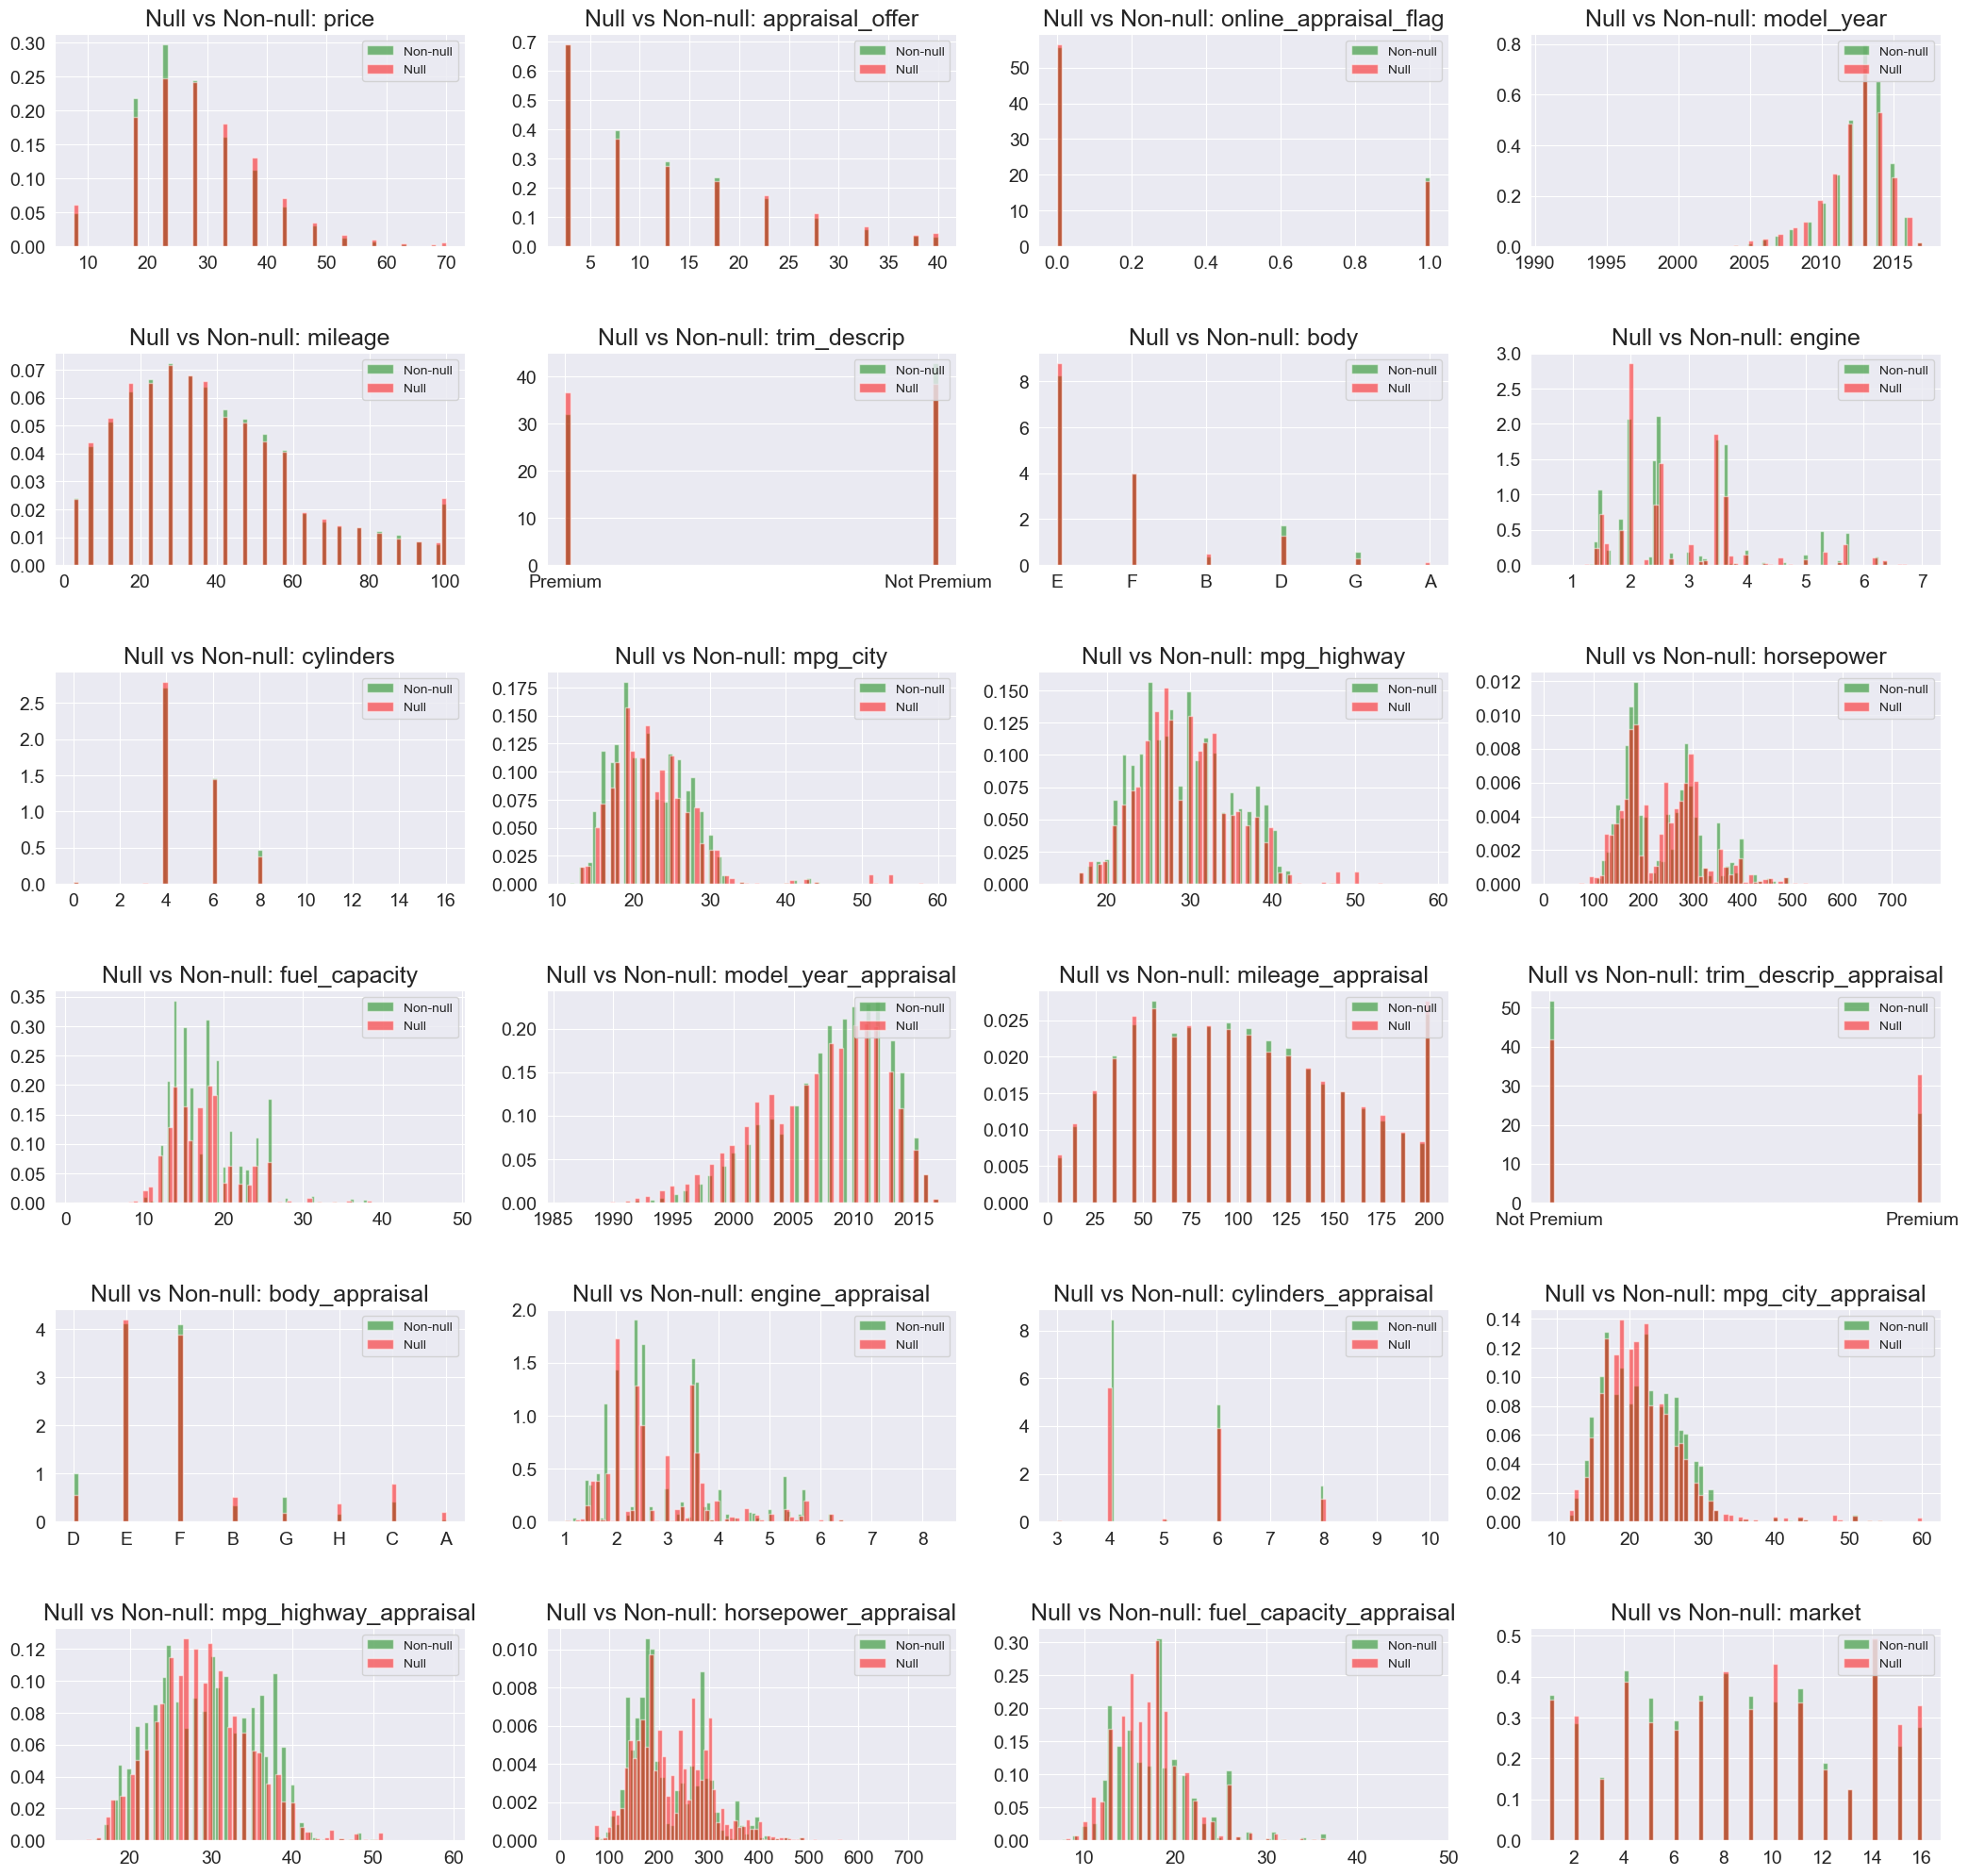

In [26]:
feats = list(trimmed_raw_df.drop(['make', 'make_appraisal', 'model', 'model_appraisal', 'color', 'color_appraisal'], axis =1).columns)
compare_hists(trimmed_raw_df, feats, len(feats), 4)

A quick way to analyze the differences between different datasets of the same schema is to overlay the distributions of each feature. In this case we have left out some non-numeric columns that have a large number of unique values, which would make it difficult to analyze.

Currently, we have the 'density' kwarg selected as true, this ensures histogram whose integral is constrained to equal one. This helps compare these two datasets, as their sizes are extremely different. From this array of histograms we can see that the distributions are mostly the same shape.

In [27]:
def compare_categorical(df: pd.DataFrame, feat : str, **kwargs):
    '''
    Takes the non-null, and partial null portions of a dataset and compares them with an superimposed bar plot
    :param df: Pandas DataFrame whose categorical feature is to be compared
    :param feat: feature to compare
    :param kwargs:
    :return: bar plot of the null, partial-null comparison
    '''

    # Null and partial null subset creation
    nn_df = df.dropna(axis = 0, how ="any")
    n_df = df[df.isna().any(axis=1)]

    fig, ax = plt.subplots()

    # Generate plots for % of each value-count
    n_df[feat].value_counts().apply(lambda x : x/n_df.shape[0]*100).plot(ax=ax, label = 'null', kind='bar', alpha = 0.5, color = 'red')
    nn_df[feat].value_counts().apply(lambda x : x/nn_df.shape[0]*100).plot(ax=ax, label = 'non-null', kind='bar', alpha = 0.5)
    plt.ylabel('% of Instances', fontsize = 14)
    plt.xlabel(feat, fontsize = 14);
    plt.legend(loc = 'upper right')
    ax.set_title(f'Comparison of {feat} Between Null and Non-Null')

    # Take off xticks; used for features that have large number of unique strings because the x-axis would be unreadable
    try:
        if kwargs['xticks'] == 'off':
            plt.xticks([],[])
    except KeyError:
        pass

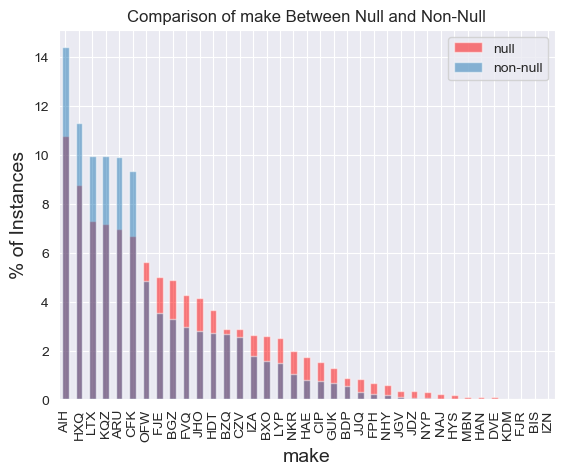

In [28]:
# Looking at the distributions of make for non-null vs null
compare_categorical(trimmed_raw_df, 'make')

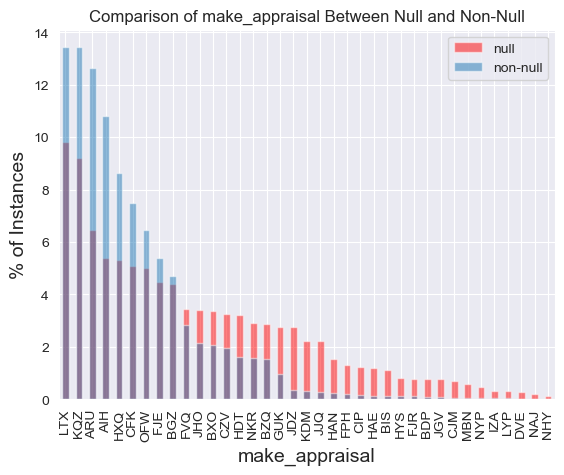

In [29]:
# Looking at the distributions of make_appraisal for non-null vs null
compare_categorical(trimmed_raw_df, 'make_appraisal')

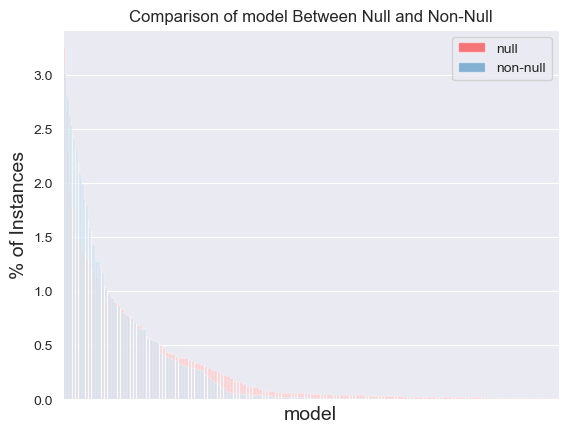

In [30]:
# Looking at the distributions of model for non-null vs null
compare_categorical(trimmed_raw_df, 'model', xticks = 'off')

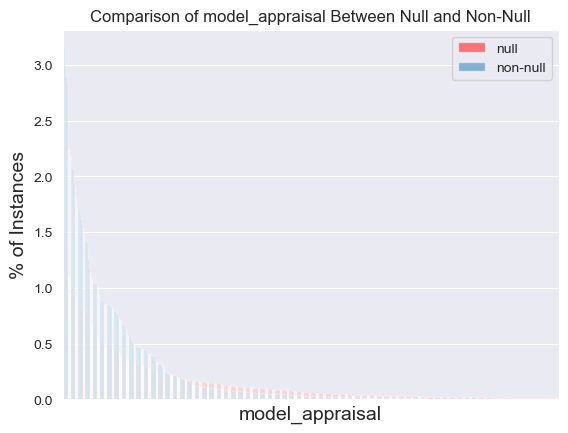

In [31]:
compare_categorical(trimmed_raw_df, 'model_appraisal', xticks = 'off')

We can see that the make and model features give different shapes for null and non-null row distributions.

**What inferences/assumptions can we make from this?** The further right in the bar graph, the fewer occurrences of this vehicle make/model appear in the dataset, meaning that the rows with nulls are more comprised of 'rarer' vehicle makes/models than rows without nulls. This may make giving a data point for every feature more difficult for the appraiser, as these rarer makes/models may lack sufficient documentation about their details.

#### Nullity Correlation

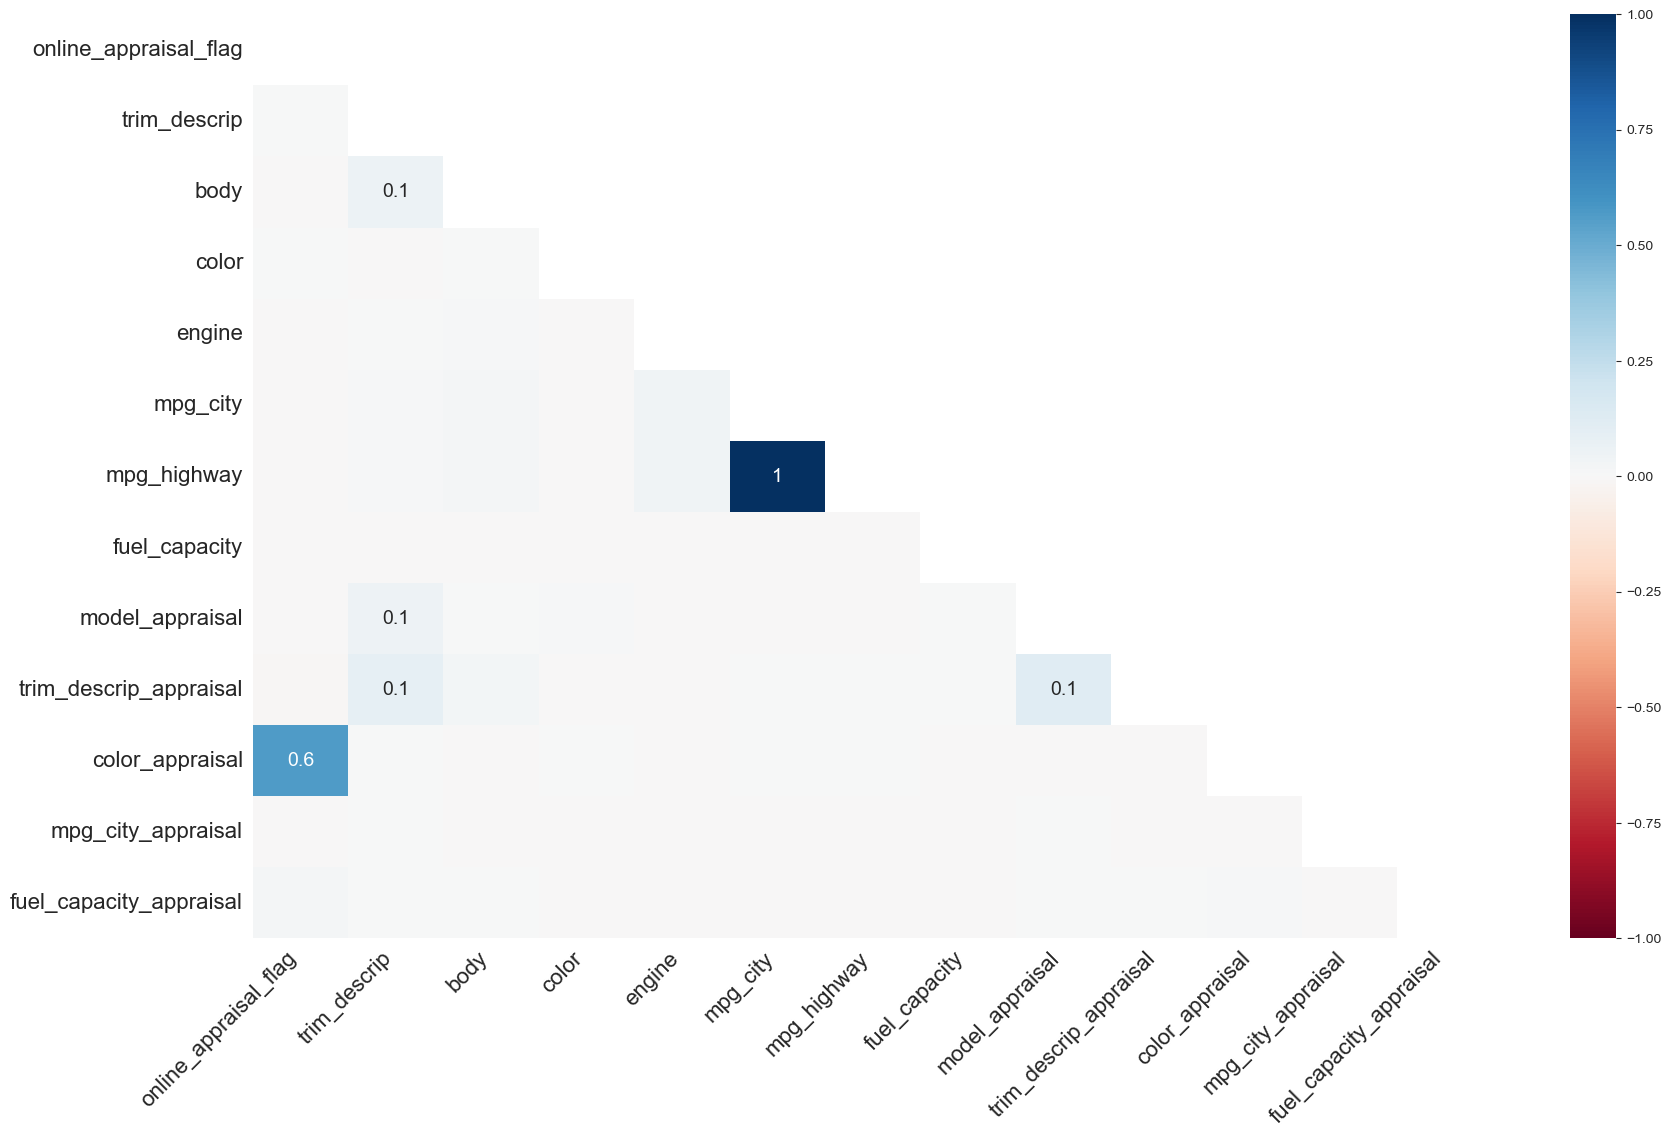

In [32]:
msno.heatmap(trimmed_raw_df);

When color_appraisal is not null, there is a high likelihood that the online_appraisal_flag will also not be null.
Additionally, if one of the mpg feature values is non-null, then it is almost certain that the other is non-null as well.

In [33]:
# Confirming the results from this nullity correlation heatmap
trimmed_raw_df[trimmed_raw_df['color_appraisal'].isna()]['online_appraisal_flag'].value_counts(dropna = False)


NaN    1279
0.0      26
1.0      13
Name: online_appraisal_flag, dtype: int64

The relationship between the color of the appraised car and the online appraisal flag, in regard to nulls, does not have any clear logical connection.

One potential explanation could be a policy/procedural change. Since there are no dates provided with the dataset instances, we cannot see any date-wise shift in data. However, it may be plausible that some kind of policy change took place regarding the entry of color data  and whether the appraisal was online.

### Correlations

In [34]:
trimmed_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   price                    200000 non-null  float16 
 1   appraisal_offer          200000 non-null  float16 
 2   online_appraisal_flag    196166 non-null  category
 3   model_year               200000 non-null  int32   
 4   mileage                  200000 non-null  float16 
 5   make                     200000 non-null  category
 6   model                    200000 non-null  object  
 7   trim_descrip             176159 non-null  category
 8   body                     189741 non-null  category
 9   color                    199967 non-null  category
 10  engine                   199999 non-null  float32 
 11  cylinders                200000 non-null  int16   
 12  mpg_city                 199410 non-null  float64 
 13  mpg_highway              199410 non-null  fl

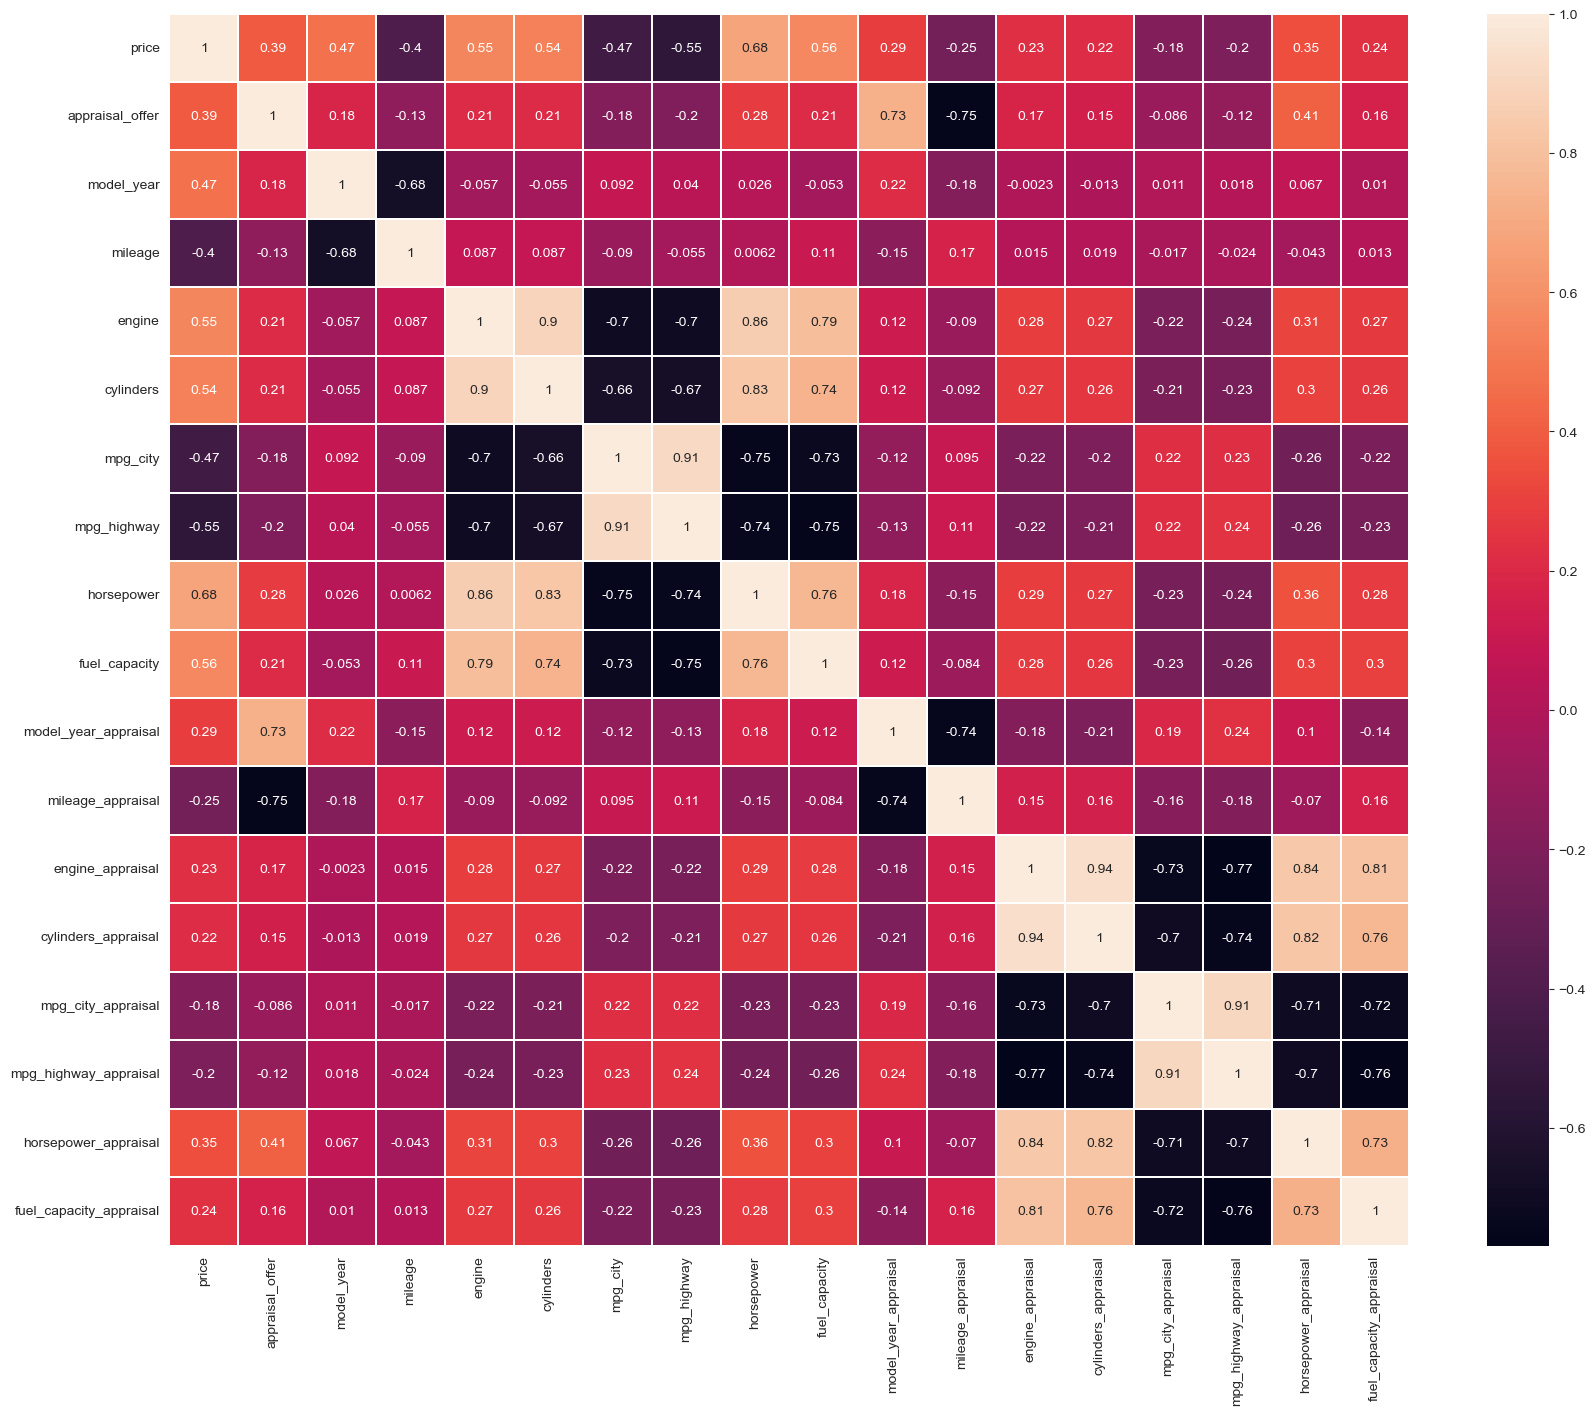

In [35]:
fig,ax = plt.subplots(figsize=(20,16))
heat_fig = sns.heatmap(trimmed_raw_df.select_dtypes(include = 'number').corr(), xticklabels = trimmed_raw_df.select_dtypes(include = 'number').columns, yticklabels = trimmed_raw_df.select_dtypes(include = 'number').columns,linewidths=0.1, annot = True)

Right away we can see some strong correlations, most of which are intuitive.

**Intuitive Correlations**
* Horsepower, engine, cylinders, and fuel capacity are all positively correlated. This makes sense because those traits intrinsically go together.
* Price positively correlates with the aforementioned traits as well as model year. This is reasonable to assume because newer cars and larger, sportier cars tend to be more expensive.
* Appraised car mileage and appraisal offer are negatively correlated.

For our purposes, we care more about the correlations between the appraised car and the purchased car.

**Appraised and Purchased Vehicle Correlations**
* Price of purchased car and the horsepower of the appraised vehicle have a slight positive correlation of 0.35.
* The appraisal offer and price of the purchased car have a slight positive correlation of 0.39.
* Horsepower, cylinders, fuel capacity, and engine trend positively with between that of the appraised and purchased vehicle.

### Cleaning Missing Values

From our analysis thus far, we've looked at the distributions of variables, the number of missing values, the primary locations of missing values.

From this information, we need to test the numerical features for normality and scope potential imputation methods.
These methods may include:
* KNN
* Mean, Median, Mode, Constant
* MICE (Multiple Imputation by Chained Equations)

<AxesSubplot:>

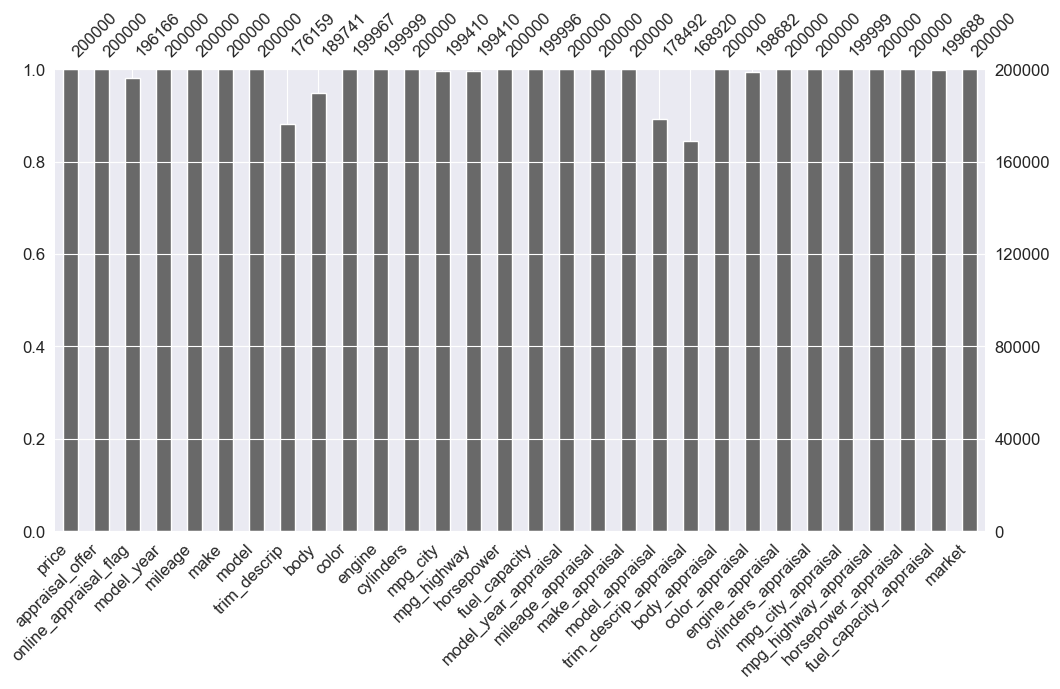

In [36]:
# Recap number and location of missing values:
msno.bar(trimmed_raw_df, figsize=(12, 6), fontsize=12)

In [37]:
# We can make different datasets, with different imputation methods, to compare performance.
# All null rows dropped
df_dropped = trimmed_raw_df.dropna()
print(f'Check no misising values in dataset with dropped nulls: {df_dropped.isna().sum().sum()==0}')

print(f'Dropping all nulls gives a dataset that is {(trimmed_raw_df.shape[0] - df_dropped.shape[0])/trimmed_raw_df.shape[0]*100:.2f} % smaller than the original.')

# We can use this dataset with dropped nulls to compare against those with imputed values.

# Features that we may want to predict:
pred_feats = ['price', 'mileage', 'make', 'model', 'trim_descrip', 'body', 'color', 'engine', 'cylinders', 'mpg_city', 'mpg_highway', 'horsepower', 'fuel capacity']


Check no misising values in dataset with dropped nulls: True
Dropping all nulls gives a dataset that is 35.66 % smaller than the original.


Prediction Options:
1. Predict one feature
    * Train a model with all features related to the appraised car, as well as the online appraisal flag and the market. Set the target to one of the purchased vehicle's features.
    * Do this for all the features of the purchased vehicle. Can we accurately predict any of these features?
2. Predict multiple features: multiclass-multioutput
    * Use a model that is compatible with a multiclass-multioutput target to predict all the purchased vehicle's features
    * Train model, give appraised car inputs, output purchased car's highest probability class for each feature
3. Clustering Algorithm: DBSCAN, Gaussian, K-means
    * Use a clustering model to cluster customer segments and recommend vehicles based on these clusters.
    * A clustering model is best suited for this kind of problem.



In [39]:
print(len(trimmed_raw_df.select_dtypes(include = 'number').columns) + len(trimmed_raw_df.select_dtypes(exclude = 'number').columns))

30


In [60]:
X, y = df_dropped.drop(['price'], axis = 1), df_dropped['price']

numerical_columns = df_dropped.select_dtypes(include = 'number').columns
categorical_columns = df_dropped.select_dtypes(exclude = 'number').columns

scaler = StandardScaler()

scaled_df = pd.get_dummies(df_dropped, columns=categorical_columns)
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)
print(scaled_df.shape)
scaled_df.head()

(128683, 930)


,price,appraisal_offer,model_year,mileage,engine,cylinders,mpg_city,mpg_highway,horsepower,fuel_capacity,...,market_7,market_8,market_9,market_10,market_11,market_12,market_13,market_14,market_15,market_16
0,-0.997026,-0.936079,-3.224836,2.567962,0.542609,0.716361,-0.615937,-0.403982,0.635000,0.059636,...,-0.276461,-0.297976,-0.275728,-0.270239,3.526169,-0.197903,-0.160305,-0.330559,-0.220258,-0.242660
1,0.551257,0.596543,-0.794274,-0.054004,-0.334070,-0.704612,-1.025233,-1.113890,0.896151,-0.632079,...,-0.276461,-0.297976,-0.275728,-0.270239,-0.283594,-0.197903,-0.160305,-0.330559,-0.220258,4.120987
2,-0.997026,-0.425205,0.177951,-0.054004,-0.421737,-0.704612,0.611952,1.015833,-0.670753,0.059636,...,-0.276461,-0.297976,-0.275728,3.700432,-0.283594,-0.197903,-0.160305,-0.330559,-0.220258,-0.242660
3,1.067352,2.895478,0.177951,-0.683276,2.909642,2.137334,-1.229882,-0.758936,2.854780,0.290207,...,-0.276461,3.355969,-0.275728,-0.270239,-0.283594,-0.197903,-0.160305,-0.330559,-0.220258,-0.242660
4,-0.997026,-0.425205,-0.308161,-0.263761,-1.298416,-0.704612,0.407304,0.128448,-1.284457,-0.862650,...,-0.276461,-0.297976,-0.275728,-0.270239,-0.283594,-0.197903,-0.160305,-0.330559,-0.220258,-0.242660


In [61]:
def run_pca(df, n_components):
    pca = PCA(n_components = n_components)
    pca_matrix = pca.fit_transform(df)
    dims = [i for i in range(1, len(pca.components_)+1)]
    pca_df_info = pd.DataFrame(np.round(pca.components_, 6), columns = df.columns)
    ratios = np.round(pca.explained_variance_ratio_.reshape(len(pca.components_), 1), 6)
    pca_df_info.insert(1, 'Explained Variance Ratio', ratios)
    return pca, pca_matrix, pca_df_info

def plot_pca(pca):
    cum_sum = np.cumsum(pca.explained_variance_ratio_)
    plt.bar(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_,
            alpha=0.5, align = 'center', label = 'Individual explained variance')
    plt.step(range(0, len(cum_sum)),
             cum_sum, where = 'mid', label = 'Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component No.')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

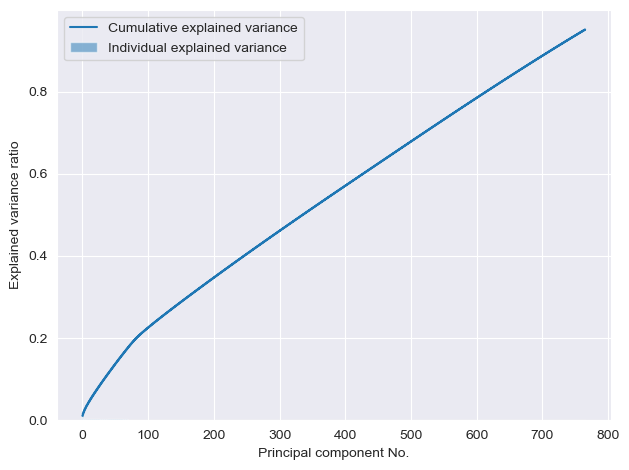

In [64]:
pca, pca_matrix, pca_df_info = run_pca(scaled_df, n_components=0.95)
plot_pca(pca)

In [57]:
print('hello')

hello


In [47]:
# Method one: Dropped all nulls
# Scale

def transform_cols(df : pd.DataFrame, feat : str):
    X, y = df.drop([feat], axis = 1), df[feat]
    print(f'X shape: {X.shape}\tY shape: {y.shape}')

    numerical_columns = df.select_dtypes(include = 'number').columns
    categorical_columns = df.select_dtypes(exclude = 'number').columns

    tforms = [('categorical', OneHotEncoder(), categorical_columns), ('numerical', StandardScaler(), numerical_columns) ]
    column_tformer = ColumnTransformer(transformers = tforms)




X shape: (200000, 29)	Y shape: (200000,)
  (0, 1)	1.0
  (0, 21)	1.0
  (1, 0)	1.0
  (1, 31)	1.0
  (2, 1)	1.0
  (2, 12)	1.0
  (3, 1)	1.0
  (3, 24)	1.0
  (4, 1)	1.0
  (4, 21)	1.0
  (5, 0)	1.0
  (5, 39)	1.0
  (6, 0)	1.0
  (6, 32)	1.0
  (7, 0)	1.0
  (7, 32)	1.0
  (8, 0)	1.0
  (8, 17)	1.0
  (9, 0)	1.0
  (9, 4)	1.0
  (9, 94)	1.0
  (10, 1)	1.0
  (10, 22)	1.0
  (11, 0)	1.0
  (11, 5)	1.0
  :	:
  (89, 39)	1.0
  (90, 0)	1.0
  (90, 21)	1.0
  (91, 0)	1.0
  (91, 9)	1.0
  (92, 0)	1.0
  (92, 4)	1.0
  (92, 94)	1.0
  (93, 0)	1.0
  (93, 31)	1.0
  (94, 0)	1.0
  (94, 3)	1.0
  (94, 44)	1.0
  (95, 1)	1.0
  (95, 33)	1.0
  (96, 0)	1.0
  (96, 4)	1.0
  (96, 94)	1.0
  (97, 1)	1.0
  (97, 32)	1.0
  (98, 0)	1.0
  (98, 3)	1.0
  (98, 54)	1.0
  (99, 1)	1.0
  (99, 31)	1.0
